# FRESH:COM



## Objective and Scope 

The energy community model FRESH:COM is developed within the [Horizon 2020 project openENTRANCE](https://openentrance.eu). 
The model is used for quantitative analyses as part of case study 2 - Behaviour of communities of actors.

### Expected results 
- Optimal design of the renewable technology portfolio for the community
- Time series of total and shared hourly local generation, storage operation, load, and purchases needed from the public grid 
    - For each community actor
    - For the community as a whole
- Revenues streams of community actors and external supplier
- Determination of the net present value of investment and operational results up to 15 years (forth-coming)
- Analyses for Austria and 4 European ‘reference countries’ (forth-coming)
- Quantitative upscaling of the short- and long-term local energy community potential is conducted for Europe as a whole (forth-coming)


## Nomenclature 
### Input data
Variable | Description      | Unit 
:--|:---------|:-----------:
$q^{PV}_{i,t}$    | PV generation of prosumer $i$                          | kWh
$q^{load}_{i,t}$  | Demand of prosumer $i$                                 | kWh
$SoC_{i}^{max}$   | Maximum capacity of prosumer $i$'s battery             | kWh
$q^{B_{max}}_{i}$ | Maximum (dis)charging power of prosumer $i$'s battery  | kW
$\eta^{B}$        | Efficiency of the batteries}                           | 
$w_{j}$           | Prosumer $j$'s weighting factor for marginal emissions | EUR/tCO2
$wtp_{i,j,t}$     | Willingness-to-pay of prosumer $j$                     | EUR/kWh
$p_{t}^{G_{in}}$  | Average spot market electricity price                  | EUR/kWh
$p_{t}^{G_{out}}$ | Retailer's electricity price                           | EUR/kWh
$e_{t}$           | Marginal emissions from the grid                       | tCO2/kWh
$\epsilon$        | Tolerance of the community                             | 
$\alpha_{i}$      | Preference for avoiding emissions or costs when choosing a new member | 

### Output data
Variable | Description      | Unit 
:--|:---------|:-----------:
$q^{G_{in}}_{i,t}$  | Purchase of prosumer $i$ from the grid     | kWh
$q^{G_{out}}_{i,t}$ | Sales from prosumer $i$ to the grid        | kWh
$q^{share}_{i,j,t}$ | Purchase of prosumer $j$ from prosumer $i$ | kWh
$q^{B_{in}}_{i,t}$  | Charging of prosumer $i$'s battery         | kWh
$q^{B_{out}}_{i,t}$ | Discharging of prosumer $i$'s battery      | kWh
$SoC_{i,t}$         | State of charge of prosumer $i$'s battery  | kWh

## Data and Packages

In [1]:
# import packages
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import tzinfo, timedelta, datetime, timezone

import pyam
import nomenclature

%matplotlib inline

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


### Model name and version, scenario, region

In [2]:
model_name = 'FRESH:COM v1.0'
scenario_name = 'Default scenario'
region_name = 'Austria'
filename_community = 'Input_data_community_small_example_IAMC.xlsx'
filename_grid = 'Input_data_grid_small_example_IAMC.xlsx'
filename_output = 'output_iamc.xlsx'

## Load data from the IIASA scenario explorer

In [3]:
# run `saving_credentials.py` with your username and password for the iiasa scenario explorer

pyam.iiasa.Connection('openentrance')
df = pyam.read_iiasa(
    'openentrance',
    model = 'GENeSYS-MOD 2.9.0-oe', 
    scenario = 'Societal Commitment 1.0')


pyam.iiasa - INFO: You are connected to the IXSE_OPENENTRANCE scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ene.iiasa.ac.at/openentrance/#/about
pyam.iiasa - INFO: You are connected as user `tperger`
pyam.iiasa - INFO: You are connected to the IXSE_OPENENTRANCE scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ene.iiasa.ac.at/openentrance/#/about
pyam.iiasa - INFO: You are connected as user `tperger`


In [4]:
df.as_pandas()

,model,scenario,region,variable,unit,year,value,exclude,version
0,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,Austria,Capacity|Electricity|Biomass,GW,2015,1.758000,False,1
1,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,Austria,Capacity|Electricity|Biomass,GW,2020,1.654000,False,1
2,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,Austria,Capacity|Electricity|Biomass,GW,2025,0.690000,False,1
3,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,Austria,Capacity|Electricity|Biomass,GW,2030,0.536000,False,1
4,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,Austria,Capacity|Electricity|Biomass,GW,2035,0.389000,False,1
...,...,...,...,...,...,...,...,...,...
11909,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,United Kingdom,Secondary Energy|Residential and Commercial He...,EJ/yr,2025,0.014316,False,1
11910,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,United Kingdom,Secondary Energy|Residential and Commercial He...,EJ/yr,2030,0.008590,False,1
11911,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,United Kingdom,Secondary Energy|Residential and Commercial He...,EJ/yr,2035,0.004295,False,1
11912,GENeSYS-MOD 2.9.0-oe,Societal Commitment 1.0,United Kingdom,Secondary Energy|Residential and Commercial He...,EJ/yr,2040,0.001748,False,1


In [5]:
def swap_subannual_for_time(df):
    """Convert an IamDataFrame with `year + subannual` to `datetime` domain"""
    if df.time_col == 'time':
        raise ValueError('The IamDataFrame already has `time` domain!')

    _data = df.data.copy()  # `copy()` can be removed after pyam release 0.8.0
    _data['time'] = _data['year'].astype('string')+'-'+_data['subannual'] 

    return pyam.IamDataFrame(_data)

In [ ]:
pyam.iiasa.Connection('openentrance')
df = pyam.read_iiasa(
    'openentrance',
    model = 'FRESH:COM v1.0', 
    scenario = 'Default scenario')

In [ ]:
df = swap_subannual_for_time(df)

### Aggregation in the time domain: preparation

In [3]:
time_zone = '+01:00' # deviation from UTC (+01:00 is CET)
start_date = '2019-01-01 00:00' # YYYY-MM-DD HH:MM
number_days = 31
delta = timedelta(hours=1) # resolution ... hourly

In [4]:
time_steps = []
for t in range(24*number_days):
    time_steps.append((datetime.fromisoformat(start_date+time_zone)+t*delta))

In [5]:
index_time = list(range(len(time_steps)))

## Read Input Data (from the IAMC Format)

In [6]:
file_community = pd.ExcelFile(filename_community)

In [7]:
prosumer = file_community.sheet_names
prosumer

['Prosumer 1',
 'Prosumer 2',
 'Prosumer 3',
 'Prosumer 4',
 'Prosumer 5',
 'Prosumer 6']

### Validation of the nomenclature of the input data

For details on the data format according to openENTRANCE see: https://github.com/openENTRANCE/nomenclature.


In [8]:
# check all sheets of the xlsx-input file seperately
for i in prosumer:
    _df = pd.read_excel(file_community, i)
    print(nomenclature.validate(_df))

True
True
True
True
True
True


### Electricity demand, PV generation, and other prosumer data

In [9]:
variable_load = 'Final Energy|Residential and Commercial|Electricity'
variable_PV = 'Secondary Energy|Electricity|Solar|PV'

In [10]:
SoC_max = 'Maximum Storage|Electricity|Energy Storage System'
SoC_min = 'Minimum Storage|Electricity|Energy Storage System'
q_bat_max = 'Maximum Charge|Electricity|Energy Storage System'
q_bat_min = 'Maximum Discharge|Electricity|Energy Storage System'
PV_capacity = 'Maximum Active power|Electricity|Solar'
w = 'Price|Carbon'

_a = [SoC_max, SoC_min, q_bat_max, q_bat_min, PV_capacity, w]

In [11]:
load = pd.DataFrame()
PV = pd.DataFrame()
prosumer_data = pd.DataFrame()

In [12]:
for i in prosumer:
    # read excel sheet and convert to pyam.IamDataFrame
    _df = pd.read_excel(file_community, i)
    _df_pyam = pyam.IamDataFrame(_df)
    
    # filter data (load)
    _data = (_df_pyam
        .filter(variable=variable_load)
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name)
        .filter(time=time_steps))
    _b = _data.as_pandas().set_index('time')
    load = pd.concat([load, _b['value'].reindex(time_steps)], axis=1).rename(columns={'value':i})
    # filter data (PV)
    _data = (_df_pyam
        .filter(variable=variable_PV)
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name)
        .filter(time=time_steps))
    _b = _data.as_pandas().set_index('time')
    PV = pd.concat([PV, _b['value'].reindex(time_steps)], axis=1).rename(columns={'value':i})
    # Prosumer data (other)
    _data = (_df_pyam
        .filter(variable=_a)
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name))
    _b = _data.as_pandas().set_index('variable')
    prosumer_data = pd.concat([prosumer_data, _b['value'].reindex(_a)], axis=1).rename(columns={'value':i})

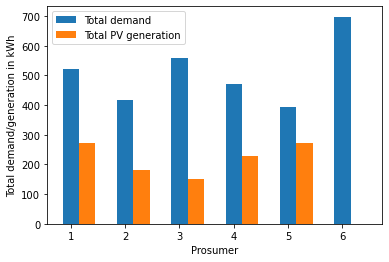

In [13]:
sum_load = [sum(load[s]) for s in prosumer] 
sum_PV = [sum(PV[s]) for s in prosumer]
barWidth = 0.3
r1 = np.arange(len(sum_load))
r2 = [x + barWidth for x in r1]
plt.bar(r1, sum_load, width = barWidth)
plt.bar(r2, sum_PV, width = barWidth)
plt.xticks(r1, np.arange(1,len(prosumer)+1))
plt.xlabel('Prosumer')
plt.ylabel('Total demand/generation in kWh')
plt.legend(['Total demand', 'Total PV generation'])
plt.show()

### Prices 

In [14]:
_df = pd.read_excel(filename_grid)
_df_pyam = pyam.IamDataFrame(_df)

In [15]:
_data = (_df_pyam
        .filter(variable='Price|Final Energy|Residential|Electricity')
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name))
p_grid_in = _data['value'].values[0]/1000

_data = (_df_pyam
        .filter(variable='Price|Secondary Energy|Electricity')
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name))
p_grid_out = _data['value'].values[0]/1000

### Emissions

In [16]:
emissions = pd.DataFrame()

_data = (_df_pyam
        .filter(variable='Emissions|CO2')
        .filter(region=region_name)
        .filter(model=model_name)
        .filter(scenario=scenario_name)
        .filter(time=time_steps))
_b = _data.as_pandas().set_index('time')
emissions = pd.concat([emissions, _b['value'].reindex(time_steps)], axis=1).rename(columns={'value':'Emissions'})

In [17]:
emissions

,Emissions
2019-01-01 00:00:00+01:00,527.400956
2019-01-01 01:00:00+01:00,538.017255
2019-01-01 02:00:00+01:00,540.011909
2019-01-01 03:00:00+01:00,550.346282
2019-01-01 04:00:00+01:00,543.508113
...,...
2019-01-31 19:00:00+01:00,684.664544
2019-01-31 20:00:00+01:00,711.306407
2019-01-31 21:00:00+01:00,722.637708
2019-01-31 22:00:00+01:00,726.516604


In [18]:
# show table / pandas dataframe of prosumer parameter
prosumer_data

,Prosumer 1,Prosumer 2,Prosumer 3,Prosumer 4,Prosumer 5,Prosumer 6
Maximum Storage|Electricity|Energy Storage System,0.0,4.0,0.0,5.0,0.0,0.0
Minimum Storage|Electricity|Energy Storage System,0.0,0.0,0.0,0.0,0.0,0.0
Maximum Charge|Electricity|Energy Storage System,0.0,1.0,0.0,1.0,0.0,0.0
Maximum Discharge|Electricity|Energy Storage System,0.0,1.0,0.0,1.0,0.0,0.0
Maximum Active power|Electricity|Solar,5.0,6.0,3.0,5.0,5.0,0.0
Price|Carbon,10.0,70.0,100.0,50.0,20.0,80.0


In [19]:
eta_battery = 0.9

In [20]:
distances = pd.read_excel('Input_data_community_small_example.xlsx', 
                              sheet_name='Distances', 
                              header=0, 
                              index_col='Prosumer')

In [28]:
distances

,Prosumer 1,Prosumer 2,Prosumer 3,Prosumer 4,Prosumer 5,Prosumer 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
Prosumer,,,,,,,,,,,,,,,,
Prosumer 1,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prosumer 2,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prosumer 3,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prosumer 4,1.0,1.0,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prosumer 5,1.0,1.0,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prosumer 6,1.0,1.0,1.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pyomo Optimization Model


## Sets

$N$ ... number of prosumers of original community

$n$ ... number of potential new prosumers (candidates)

$n_{max}, n_{min}$ ... number of maxiumum/minimum number of new prosumers

## Decision variables

$q_{i,t}^{G_{in}},q_{i,t}^{G_{out}},q_{i,j,t}^{share},q_{i,t}^{B_{in}},q_{i,t}^{B_{out}},SoC_{i,t}\in\mathbb{R}^{+}$

$b_{i}\in\{0,1\}$ ... for $i\in n$

$b_{i}=1$ ... for $i\in N$

## Objective function

$\underset{\substack{\{q_{i,t}^{G_{in}},q_{i,t}^{G_{out}},q_{i,j,t}^{share},q_{i,t}^{B_{in}},q_{i,t}^{B_{out}},SoC_{i,t},b_{i}\}}}{\text{max}} \sum_{t\in\mathcal{T},i\in\mathcal{I}}^{}p_t^{G_{out}}q_{i,t}^{G_{out}}-\sum_{t\in\mathcal{T},i\in\mathcal{I}}^{}p_t^{G_{in}}q_{i,t}^{G_{in}}+\sum_{t\in\mathcal{T},i,j\in\mathcal{I}}^{}wtp_{i,j,t}q_{i,j,t}^{share}$

## Constraints

$b_{i}q_{i,t}^{load}=q_{i,t}^{G_{in}}+q_{i,t}^{B_{out}}+\sum_{j\in\mathcal{I}}^{}q_{j,i,t}^{share}$

$b_{i}q_{i,t}^{PV}=q_{i,t}^{G_{out}}+q_{i,t}^{B_{in}}+\sum_{j\in\mathcal{I}}^{}q_{i,j,t}^{share}$

$SoC_{i,t}=SoC_{i,t-1}+q_{i,t}^{B_{in}}\cdot\eta^B-q_{i,t}^{B_{out}}/\eta^B$

$SoC_{i}^{min}\leq SoC_{i,t}\leq b_{i}SoC_{i}^{max}$

$q_{i,t}^{B_{in}},q_{i,t}^{B_{out}}\leq b_{i}q_{i}^{B_{max}}$

$q_{i,t}^{G_{in}},q_{i,t}^{G_{out}},q_{i,j,t}^{share},q_{i,t}^{B_{in}},q_{i,t}^{B_{out}},SoC_{i,t}\geq0$

### Additional (optional) constrains 

$\sum_{i}^{}b_{i} >= N+n_{min}$

$\sum_{i}^{}b_{i} <= N+n_{max}$

## Check results
$\alpha_i \Delta_{Costs,i}+ (1-\alpha_i)\Delta_{Emissions,i} \leq \epsilon$


In [21]:
N = 4 # number of 'old' prosumers
n = 2 # number of 'new' prosumers
#prosumer_old = prosumer[0:N] 
#prosumer_new = prosumer[N:N+n]
prosumer_old = (['Prosumer 1','Prosumer 3','Prosumer 5','Prosumer 6'])


In [25]:
# deactivate BESS
#for i in prosumer:
#    prosumer_data.loc['SoC_max',i] = 0
#    prosumer_data.loc['q_bat_max',i] = 0

## Solve optimization problem for old community and define benchmarks

... as LP

In [22]:
# Define model as concrete model
model = ConcreteModel()

#Define optimization variables 
model.q_share = Var(time_steps, prosumer_old, prosumer_old, within = NonNegativeReals)
model.q_grid_in = Var(time_steps, prosumer_old, within = NonNegativeReals)
model.q_grid_out = Var(time_steps, prosumer_old, within = NonNegativeReals)
model.q_bat_in = Var(time_steps, prosumer_old, within = NonNegativeReals)
model.q_bat_out = Var(time_steps, prosumer_old, within = NonNegativeReals)
model.SoC = Var(time_steps, prosumer_old, within = NonNegativeReals)

In [23]:
# Define constraints
def load_constraint_rule(model, i, t):    
    return model.q_grid_in[t,i] + model.q_bat_out[t,i] + sum(model.q_share[t,j,i] for j in prosumer_old) == load.loc[t,i]
model.load_con = Constraint(prosumer_old, time_steps, rule = load_constraint_rule)

def PV_constraint_rule(model, i, t):    
    return model.q_grid_out[t,i] + model.q_bat_in[t,i] + sum(model.q_share[t,i,j] for j in prosumer_old) == PV.loc[t,i]
model.PV_con = Constraint(prosumer_old, time_steps, rule = PV_constraint_rule)

def SoC_min_constraint_rule(model, i, t):
    return model.SoC[t,i] >= prosumer_data.loc[SoC_min][i]
model.SoC_min_con = Constraint(prosumer_old, time_steps, rule = SoC_min_constraint_rule)

def SoC_max_constraint_rule(model, i, t):
    return model.SoC[t,i] <= prosumer_data.loc[SoC_max][i]
model.SoC_max_con = Constraint(prosumer_old, time_steps, rule = SoC_max_constraint_rule)

def q_bat_in_constraint_rule(model, i, t):
    return model.q_bat_in[t,i] <= prosumer_data.loc[q_bat_max][i]
model.q_bat_in_con = Constraint(prosumer_old, time_steps, rule = q_bat_in_constraint_rule)

def q_bat_out_constraint_rule(model, i, t):
    return model.q_bat_out[t,i] <= prosumer_data.loc[q_bat_max][i]
model.q_bat_out_con = Constraint(prosumer_old, time_steps, rule = q_bat_out_constraint_rule)

def SoC_constraint_rule(model, i, t):
    if t == 0:
        return model.SoC[time_steps[t],i] == 0 + model.q_bat_in[time_steps[t],i]*eta_battery - model.q_bat_out[time_steps[t],i]/eta_battery
    elif t > 0:
        return model.SoC[time_steps[t],i] == model.SoC[time_steps[t-1],i] + model.q_bat_in[time_steps[t],i]*eta_battery - model.q_bat_out[time_steps[t],i]/eta_battery
model.SoC_con = Constraint(prosumer_old, index_time, rule = SoC_constraint_rule)

In [24]:
# Objective function
community_welfare = {new_list: [] for new_list in prosumer_old}
prosumer_welfare = {new_list: [] for new_list in prosumer_old}
prosumer_welfare2 = {new_list: [] for new_list in prosumer_old}


for i in prosumer_old:
    community_welfare[i] = sum(-p_grid_in*model.q_grid_in[t,i]+p_grid_out*model.q_grid_out[t,i] for t in time_steps)
    prosumer_welfare[i] = sum((p_grid_in + (prosumer_data.loc[w,j] - distances.loc[i,j])*emissions.Emissions.loc[t]/1000000)*model.q_share[t,i,j] for j in prosumer_old for t in time_steps)
    prosumer_welfare2[i] = sum((p_grid_in + (prosumer_data.loc[w,i] - distances.loc[j,i])*emissions.Emissions.loc[t]/1000000)*model.q_share[t,j,i] for j in prosumer_old for t in time_steps)

# 1. prosumer i sells to prosumer j
# 2. prosumer i buys from prosumer j

In [25]:
model.obj = Objective(
    expr = sum(community_welfare[i] + prosumer_welfare[i] for i in prosumer_old), 
    sense = maximize)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

In [26]:
# Evaluate the results
social_welfare_old = value(model.obj)

q_share_total = pd.DataFrame(index=prosumer_old)
for j in prosumer_old:
    a = []
    for i in prosumer_old:
        a.append(value(sum(model.q_share[t,i,j] for t in time_steps)))
    q_share_total[j] = a

results_old = pd.DataFrame(index=prosumer_old)
for i in prosumer_old:
    results_old.loc[i,'buying grid'] = value(sum(model.q_grid_in[t,i] for t in time_steps))
    results_old.loc[i,'selling grid'] = value(sum(model.q_grid_out[t,i] for t in time_steps))
    results_old.loc[i,'battery charging'] = value(sum(model.q_bat_in[t,i] for t in time_steps))
    results_old.loc[i,'battery discharging'] = value(sum(model.q_bat_out[t,i] for t in time_steps))
    results_old.loc[i,'self-consumption'] = q_share_total.loc[i,i]
    results_old.loc[i,'buying community'] = sum(q_share_total.loc[j,i] for j in prosumer_old) - q_share_total.loc[i,i]
    results_old.loc[i,'selling community'] = sum(q_share_total.loc[i,j] for j in prosumer_old) - q_share_total.loc[i,i]
    results_old.loc[i,'emissions'] = value(sum(model.q_grid_in[t,i]*emissions.Emissions.loc[t]/1000000 for t in time_steps))
    results_old.loc[i,'costs'] = value(-community_welfare[i]) - value(prosumer_welfare[i]) + value(prosumer_welfare2[i]) 


In [27]:
results_old

,buying grid,selling grid,battery charging,battery discharging,self-consumption,buying community,selling community,emissions,costs
Prosumer 1,447.902329,83.014144,0.0,0.0,43.604315,28.662114,144.149541,0.282032,55.348071
Prosumer 3,383.380752,3.692008,0.0,0.0,57.253490,118.372340,90.704502,0.243352,85.999468
Prosumer 5,295.268407,114.427971,0.0,0.0,94.449230,4.573389,61.890800,0.187003,39.790213
Prosumer 6,552.654438,0.000000,0.0,0.0,0.000000,145.137000,0.000000,0.349694,146.625887


In [32]:
social_welfare_old

-523.6415606924937

In [33]:
q_share_total

,Prosumer 1,Prosumer 3,Prosumer 5,Prosumer 6
Prosumer 1,907.149977,1225.814568,23.285942,1015.185835
Prosumer 3,1098.372097,1068.155836,6.485351,1536.438300
Prosumer 5,111.784940,394.684732,1465.466590,298.203008
Prosumer 6,0.000000,0.000000,0.000000,0.000000


## Write to IAMC format

In [34]:
# Define function 

def write_IAMC(output_df, model, scenario, region, variable, unit, time, values):
    
    _df=pd.DataFrame({'model': model,
                  'scenario': scenario,
                  'region': region,
                  'variable': variable,
                  'unit': unit,
                  'time': time,
                  'value': values})
    output_df = output_df.append(_df)
    return output_df


In [35]:
output_iamc = pd.DataFrame()

### Write annual data to IAMC format

In [36]:
_value = [value(sum(model.q_grid_out[t,i] for i in prosumer_old for t in time_steps))]
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Secondary Energy|Electricity|Solar|PV', 'kWh/yr', start_date+time_zone, _value)

_value = [value(sum(model.q_grid_in[t,i] for i in prosumer_old for t in time_steps))]
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Final Energy|Residential and Commercial|Electricity', 'kWh/yr', start_date+time_zone, _value)

_value = [value(sum(model.q_grid_in[t,i]*emissions.Emissions.loc[t]/1000000 for i in prosumer_old for t in time_steps))]
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Emissions|CO2', 'tCO2/yr', start_date+time_zone, _value)

### Write hourly data to IAMC format

In [37]:
# selling to the grid as a community (hourly resolution)
_value = []
for t in time_steps:
    _value.append(value(sum(model.q_grid_out[t,i] for i in prosumer_old)))
    
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Secondary Energy|Electricity|Solar|PV', 'kWh', time_steps, _value)

In [38]:
# buying from the grid as a community (hourly resolution)
_value = []
for t in time_steps:
    _value.append(value(sum(model.q_grid_in[t,i] for i in prosumer_old)))
    
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Final Energy|Residential and Commercial|Electricity', 'kWh', time_steps, _value)

In [39]:
# emissions of the community (hourly resolution)
_value = []
for t in time_steps:
    _value.append(value(sum(model.q_grid_in[t,i]*emissions.Emissions.loc[t]/1000000 for i in prosumer_old)))
    
output_iamc = write_IAMC(output_iamc, model_name, scenario_name, region_name, 'Emissions|CO2', 'tCO2', time_steps, _value)

In [40]:
output_iamc

,model,scenario,region,variable,unit,time,value
0,FRESH:COM v1.0,Default scenario,Austria,Secondary Energy|Electricity|Solar|PV,kWh/yr,2019-01-01 00:00+01:00,7630.138825
0,FRESH:COM v1.0,Default scenario,Austria,Final Energy|Residential and Commercial|Electr...,kWh/yr,2019-01-01 00:00+01:00,14628.212489
0,FRESH:COM v1.0,Default scenario,Austria,Emissions|CO2,tCO2/yr,2019-01-01 00:00+01:00,7.871476
0,FRESH:COM v1.0,Default scenario,Austria,Secondary Energy|Electricity|Solar|PV,kWh,2019-01-01 00:00:00+01:00,0.000000
1,FRESH:COM v1.0,Default scenario,Austria,Secondary Energy|Electricity|Solar|PV,kWh,2019-01-01 01:00:00+01:00,0.000000
...,...,...,...,...,...,...,...
8755,FRESH:COM v1.0,Default scenario,Austria,Emissions|CO2,tCO2,2019-12-31 19:00:00+01:00,0.001365
8756,FRESH:COM v1.0,Default scenario,Austria,Emissions|CO2,tCO2,2019-12-31 20:00:00+01:00,0.000945
8757,FRESH:COM v1.0,Default scenario,Austria,Emissions|CO2,tCO2,2019-12-31 21:00:00+01:00,0.000982
8758,FRESH:COM v1.0,Default scenario,Austria,Emissions|CO2,tCO2,2019-12-31 22:00:00+01:00,0.000591


In [41]:
output_iamc['time'] = output_iamc['time'].astype('string')

In [42]:
output_iamc.to_excel(filename_output, index=None)

## Show results of optimization problem

### P2P trading in detail 

In [ ]:
q_share_total = pd.DataFrame(index=prosumer)
for j in prosumer:
    a = []
    for i in prosumer:
        a.append(value(sum(model.q_share[t,i,j] for t in time_steps)))
    q_share_total[j] = a
q_share_total

In [ ]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(q_share_total, annot=True, cmap="Blues", linewidths=.5, ax=ax)

### Costs, emissions, etc for each prosumer

In [ ]:
results = pd.DataFrame(index=prosumer)
for i in prosumer:
    results.loc[i,'buying grid'] = value(sum(model.q_grid_in[t,i] for t in time_steps))
    results.loc[i,'selling grid'] = value(sum(model.q_grid_out[t,i] for t in time_steps))
    results.loc[i,'battery charging'] = value(sum(model.q_bat_in[t,i] for t in time_steps))
    results.loc[i,'battery discharging'] = value(sum(model.q_bat_out[t,i] for t in time_steps))
    results.loc[i,'self-consumption'] = q_share_total.loc[i,i]
    results.loc[i,'buying community'] = sum(q_share_total.loc[j,i] for j in prosumer) - q_share_total.loc[i,i]
    results.loc[i,'selling community'] = sum(q_share_total.loc[i,j] for j in prosumer) - q_share_total.loc[i,i]
    results.loc[i,'emissions'] = value(sum(model.q_grid_in[t,i]*emissions.Emissions.loc[t]/1000 for t in time_steps))
    results.loc[i,'costs'] = value(-community_welfare[i]) - value(prosumer_welfare[i]) + value(prosumer_welfare2[i])  
results

## License

   [<img style="float: right;" src="https://img.shields.io/badge/License-Apache%202.0-blue.svg">](https://opensource.org/licenses/Apache-2.0)
   
   Copyright 2020 Theresia Perger

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

## Refererences